# Question 1: Control VAE

* Dataset -  dSprites (2D shape)
* Models: VAE | Control VAE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import requests
import zipfile
import io

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.optim as optim
import torch

## 1-1. Intro - load data

In [3]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(path_file, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

In [5]:
for i in range(10):
    print(f"Image {i + 1} size: {imgs[i].shape}")

Image 1 size: (64, 64)
Image 2 size: (64, 64)
Image 3 size: (64, 64)
Image 4 size: (64, 64)
Image 5 size: (64, 64)
Image 6 size: (64, 64)
Image 7 size: (64, 64)
Image 8 size: (64, 64)
Image 9 size: (64, 64)
Image 10 size: (64, 64)


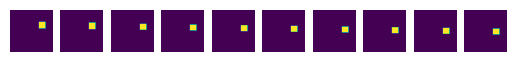

In [6]:
import matplotlib.pyplot as plt


num_samples_to_display = 10

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(imgs[i+1000])
    plt.axis('off')

plt.show()


## Dataloader

In [45]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

class DspritesDataset(Dataset):
    def __init__(self, imgs):
        self.data = imgs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx]).float()
        sample = sample.unsqueeze(0)
        return sample

def load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2, shuffle_dataset=True, random_seed=42):
    # Load the dataset
    imgs = np.load(path_file, allow_pickle=True, encoding='latin1')['imgs']

    # Define the transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = DspritesDataset(imgs)

    # Split the dataset into training and validation sets
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

# Example usage
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
train_loader, val_loader = load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2)


In [8]:
train_loader

In [15]:
print("Image shape:", imgs[0].shape)

Image shape: (64, 64)


## 2-1. VAE

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

class VAE_Simple(nn.Module):
    def __init__(self, input_size=64*64, hidden_size=256, latent_size=10):
        super(VAE_Simple, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64*64))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64*64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

model = VAE_Simple()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def accuracy(recon_x, x):
    # Use a threshold to determine predicted class
    predicted = recon_x.view(-1) > 0.5
    correct = (predicted == x.view(-1).byte()).float()
    acc = correct.sum() / x.numel()
    return acc.item()


# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    for data in train_loader:
        inputs = data.float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar)
        acc = accuracy(recon_batch, inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    average_loss = total_loss / len(train_loader.dataset)
    average_acc = total_acc / len(train_loader.dataset)

    print(f'Train Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Acc: {average_acc:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs = data.float()
            recon_batch, mu, logvar = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar)
            acc = accuracy(recon_batch, inputs)

            val_loss += loss.item()
            val_acc += acc

    average_val_loss = val_loss / len(val_loader.dataset)
    average_val_acc = val_acc / len(val_loader.dataset)

    print(f'Validation Epoch {epoch + 1}/{num_epochs}, Loss: {average_val_loss:.4f}, Acc: {average_val_acc:.4f}')


Train Epoch 1/2, Loss: 1053.4529, Acc: 0.0113
Validation Epoch 1/2, Loss: 157.5542, Acc: 0.0030
Train Epoch 2/2, Loss: 497.7572, Acc: 0.0120
Validation Epoch 2/2, Loss: 93.8927, Acc: 0.0030


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*8*8, 64)
        self.fc_logvar = nn.Linear(128*8*8, 64)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Instantiate the model and set up the optimizer
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    vae.train()
    for data in train_loader:
        inputs = data.float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = vae(inputs)

        # Compute the reconstruction loss and the KL divergence
        reconstruction_loss = F.binary_cross_entropy(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        print("Epoch {}, Loss: {:.4f}".format(epoch + 1, loss.item()))


Epoch 1, Loss: 196410.3281
Epoch 1, Loss: 186054.7656
Epoch 1, Loss: 166692.9219
Epoch 1, Loss: 123395.0078
Epoch 1, Loss: 267632.9062
Epoch 1, Loss: 89693.9219
Epoch 1, Loss: 80089.7578
Epoch 1, Loss: 79718.1641
Epoch 1, Loss: 74650.4609
Epoch 1, Loss: 71794.8984
Epoch 1, Loss: 64521.9219
Epoch 1, Loss: 65477.0938
Epoch 1, Loss: 52794.8359
Epoch 1, Loss: 62126.2305
Epoch 1, Loss: 54092.8750
Epoch 1, Loss: 61516.6680
Epoch 1, Loss: 55519.0547
Epoch 1, Loss: 63195.8320
Epoch 1, Loss: 61553.8398
Epoch 1, Loss: 59836.1016
Epoch 1, Loss: 59550.6758
Epoch 1, Loss: 50141.9023
Epoch 1, Loss: 54436.9531
Epoch 1, Loss: 48436.0273
Epoch 1, Loss: 48285.4453
Epoch 1, Loss: 48826.1562
Epoch 1, Loss: 45845.2188
Epoch 1, Loss: 42814.2422
Epoch 1, Loss: 41435.0195
Epoch 1, Loss: 44052.3242
Epoch 1, Loss: 42457.1641
Epoch 1, Loss: 43000.6172
Epoch 1, Loss: 40381.4102
Epoch 1, Loss: 41862.6133
Epoch 1, Loss: 39130.6055
Epoch 1, Loss: 40894.2266
Epoch 1, Loss: 38674.7305
Epoch 1, Loss: 38854.0430
Epoch 1

In [48]:
for epoch in range(2):  # Change the number of epochs as needed
    model.train()
    for data in train_loader:
        inputs = data.float()
        print("Input shape: (barch | channel | height and width)", inputs.size())

Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64